1. Загрузите данные из файла "База.csv"

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Загрузка данных
uploaded_files = files.upload()

# Чтение данных с измененными переменными
property_data = pd.DataFrame()
for file_name in uploaded_files.keys():
    property_data = pd.read_csv(file_name,
                      usecols=['УИД_Брони', 'ДатаБрони', 'ВремяБрони', 'ИсточникБрони', 'ВременнаяБронь', 'СледующийСтатус', 'Город',
                               'ВидПомещения', 'Тип', 'ПродаваемаяПлощадь', 'Этаж', 'СтоимостьНаДатуБрони', 'ТипСтоимости', 'ВариантОплаты',
                               'ВариантОплатыДоп', 'СкидкаНаКвартиру', 'ФактическаяСтоимостьПомещения', 'СделкаАН', 'ИнвестиционныйПродукт',
                               'Привилегия', 'Статус лида (из CRM)'],
                      delimiter=';',
                      encoding='windows-1251')
    print(f"Загружен файл: {file_name}")

print(property_data)

Saving База.csv to База.csv
Загружен файл: База.csv
                                 УИД_Брони   ДатаБрони ВремяБрони  \
0     d192173f-fc14-11eb-9512-000c29ad50ac  13.08.2021    1:00:01   
1     43574a1f-fe8b-11eb-9512-000c29ad50ac  16.08.2021    4:12:46   
2     0e7b7a81-fe97-11eb-9512-000c29ad50ac  16.08.2021    5:37:12   
3     c7041428-f90b-11eb-9512-000c29ad50ac  09.08.2021    4:17:35   
4     60090518-fe8b-11eb-9512-000c29ad50ac  16.08.2021    4:13:35   
...                                    ...         ...        ...   
5514  945845a1-6269-11ec-951b-000c29ad50ac  21.12.2021    6:23:36   
5515  4f131bfb-78f4-11ec-951d-000c29ad50ac  19.01.2022   10:52:06   
5516  74f0e184-78fc-11ec-951d-000c29ad50ac  19.01.2022   11:50:23   
5517  12866ac0-7902-11ec-951d-000c29ad50ac  19.01.2022   12:30:40   
5518  74646d42-6969-11ec-951b-000c29ad50ac  30.12.2021    4:10:21   

     ИсточникБрони ВременнаяБронь СледующийСтатус             Город  \
0           ручная             Да        Свободн

2. Предварительная фильтрация.

a. Поскольку нас интересуют только сделки с жилой недвижимостью, отфильтруйте данные, оставив только те, для которых «ВидПомещения» = «жилые помещения». В дальнейшем этот столбец использоваться не будет, его можно удалить (или удалите его из датасета вообще, или просто нигде далее не рассматривайте).

In [3]:
property_data = property_data[property_data['ВидПомещения']=='жилые помещения']
del property_data['ВидПомещения']

b. Также для нас бесполезны данные, по которым статус не определен. Отфильтруйте данные по признаку «СледующийСтатус». В оставшихся строчках замените значение «Продана» на 1, «Свободна» – на 0.

In [4]:
property_data = property_data[property_data['СледующийСтатус'].notna() & (property_data['СледующийСтатус'] != 'В резерве')]
property_data['СледующийСтатус'] = property_data['СледующийСтатус'].map({'Продана': 1, 'Свободна': 0})
print(property_data)

                                 УИД_Брони   ДатаБрони ВремяБрони  \
0     d192173f-fc14-11eb-9512-000c29ad50ac  13.08.2021    1:00:01   
1     43574a1f-fe8b-11eb-9512-000c29ad50ac  16.08.2021    4:12:46   
2     0e7b7a81-fe97-11eb-9512-000c29ad50ac  16.08.2021    5:37:12   
3     c7041428-f90b-11eb-9512-000c29ad50ac  09.08.2021    4:17:35   
4     60090518-fe8b-11eb-9512-000c29ad50ac  16.08.2021    4:13:35   
...                                    ...         ...        ...   
5507  5866fe67-543a-11ec-9518-000c29ad50ac  03.12.2021    5:10:13   
5512  30127467-6304-11ec-951b-000c29ad50ac  22.12.2021   12:50:18   
5514  945845a1-6269-11ec-951b-000c29ad50ac  21.12.2021    6:23:36   
5516  74f0e184-78fc-11ec-951d-000c29ad50ac  19.01.2022   11:50:23   
5518  74646d42-6969-11ec-951b-000c29ad50ac  30.12.2021    4:10:21   

     ИсточникБрони ВременнаяБронь  СледующийСтатус             Город   Тип  \
0           ручная             Да                0         Ярославль  2,5к   
1           руч

c. Не забывайте, что столбец «УИД_Брони» для нас также не представляет интереса – удалите его из датасета вообще, или просто нигде далее не рассматривайте.

In [5]:
del property_data['УИД_Брони']

Также уберем дату и время бронирования, поскольку в задании не указано о их преобразовании, а для нормализации данных требуются числовые типы - они создадут дополнительные сложности, от которых проще избавиться

In [6]:
del property_data['ДатаБрони']
del property_data['ВремяБрони']

3. Проверьте тип данных и преобразуйте все данные к числовому типу

a. Для тех полей, которые по смыслу являются числовыми (например, «ПродаваемаяПлощадь») – просто проверьте правильность типа

In [7]:
property_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3944 entries, 0 to 5518
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ИсточникБрони                  3944 non-null   object 
 1   ВременнаяБронь                 3944 non-null   object 
 2   СледующийСтатус                3944 non-null   int64  
 3   Город                          3944 non-null   object 
 4   Тип                            3900 non-null   object 
 5   ПродаваемаяПлощадь             3900 non-null   object 
 6   Этаж                           3944 non-null   float64
 7   СтоимостьНаДатуБрони           3944 non-null   object 
 8   ТипСтоимости                   3944 non-null   object 
 9   ВариантОплаты                  3941 non-null   object 
 10  ВариантОплатыДоп               2218 non-null   object 
 11  СкидкаНаКвартиру               698 non-null    object 
 12  ФактическаяСтоимостьПомещения  3944 non-null   object

In [8]:
property_data['ПродаваемаяПлощадь'] = property_data['ПродаваемаяПлощадь'].str.replace(',', '.').astype(float)
property_data['Этаж'] = property_data['Этаж'].astype(int)
property_data['СтоимостьНаДатуБрони'] = property_data['СтоимостьНаДатуБрони'].str.replace(',', '.').astype(float)
property_data['СкидкаНаКвартиру'] = property_data['СкидкаНаКвартиру'].str.replace(',', '.').astype(float)
property_data['ФактическаяСтоимостьПомещения'] = property_data['ФактическаяСтоимостьПомещения'].str.replace(',', '.').astype(float)
property_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3944 entries, 0 to 5518
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ИсточникБрони                  3944 non-null   object 
 1   ВременнаяБронь                 3944 non-null   object 
 2   СледующийСтатус                3944 non-null   int64  
 3   Город                          3944 non-null   object 
 4   Тип                            3900 non-null   object 
 5   ПродаваемаяПлощадь             3900 non-null   float64
 6   Этаж                           3944 non-null   int64  
 7   СтоимостьНаДатуБрони           3944 non-null   float64
 8   ТипСтоимости                   3944 non-null   object 
 9   ВариантОплаты                  3941 non-null   object 
 10  ВариантОплатыДоп               2218 non-null   object 
 11  СкидкаНаКвартиру               698 non-null    float64
 12  ФактическаяСтоимостьПомещения  3944 non-null   float6

b. Для бинарных признаков (например, «ИсточникБрони») выполните кодирование (один вариант закодируйте 0, другой 1)

In [9]:
property_data['ИсточникБрони'] = property_data['ИсточникБрони'].map({'ручная': 1, 'МП': 0})
property_data['ВременнаяБронь'] = property_data['ВременнаяБронь'].map({'Да': 1, 'Нет': 0})
property_data['ТипСтоимости'] = property_data['ТипСтоимости'].map({'Стоимость при 100% оплате': 1, 'Стоимость в рассрочку': 0})
property_data['ВариантОплаты'] = property_data['ВариантОплаты'].map({'Единовременная оплата': 1, 'Оплата в рассрочку': 0})
property_data['ВариантОплатыДоп'] = property_data['ВариантОплатыДоп'].map({'Ипотека': 1, 'Вторичное жилье': 0})
property_data['СделкаАН'] = property_data['СделкаАН'].map({'Да': 1, 'Нет': 0})
property_data['ИнвестиционныйПродукт'] = property_data['ИнвестиционныйПродукт'].map({'Да': 1, 'Нет': 0})
property_data['Привилегия'] = property_data['Привилегия'].map({'Да': 1, 'Нет': 0})
property_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3944 entries, 0 to 5518
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ИсточникБрони                  3944 non-null   int64  
 1   ВременнаяБронь                 3944 non-null   int64  
 2   СледующийСтатус                3944 non-null   int64  
 3   Город                          3944 non-null   object 
 4   Тип                            3900 non-null   object 
 5   ПродаваемаяПлощадь             3900 non-null   float64
 6   Этаж                           3944 non-null   int64  
 7   СтоимостьНаДатуБрони           3944 non-null   float64
 8   ТипСтоимости                   3944 non-null   int64  
 9   ВариантОплаты                  3941 non-null   float64
 10  ВариантОплатыДоп               2218 non-null   float64
 11  СкидкаНаКвартиру               698 non-null    float64
 12  ФактическаяСтоимостьПомещения  3944 non-null   float6

c. Для категориальных не бинарных признаков (например, «Город») выполните one-hot кодирование.

In [10]:
property_data = pd.get_dummies(property_data,
                           columns=['Город', 'Статус лида (из CRM)'],
                           prefix=['Город', 'Статус_лида'])
property_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3944 entries, 0 to 5518
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ИсточникБрони                  3944 non-null   int64  
 1   ВременнаяБронь                 3944 non-null   int64  
 2   СледующийСтатус                3944 non-null   int64  
 3   Тип                            3900 non-null   object 
 4   ПродаваемаяПлощадь             3900 non-null   float64
 5   Этаж                           3944 non-null   int64  
 6   СтоимостьНаДатуБрони           3944 non-null   float64
 7   ТипСтоимости                   3944 non-null   int64  
 8   ВариантОплаты                  3941 non-null   float64
 9   ВариантОплатыДоп               2218 non-null   float64
 10  СкидкаНаКвартиру               698 non-null    float64
 11  ФактическаяСтоимостьПомещения  3944 non-null   float64
 12  СделкаАН                       3944 non-null   int64 

d. Обратите внимание на поле «Тип». По смыслу оно числовое (количество комнат), но напрямую сконвертировать его в числовой тип мешает буковка «к» в конце. Напишите вручную преобразование, которое удаляет букву «к» в конце и конвертирует то, что осталось, в число. Если это невозможно (среди данных вам встретится еще вариант, когда в этом поле записано просто «с») – просто пока оставьте поле пустым (NaN).

In [11]:
def convert_room_type(value):
    value_str = str(value).strip()

    if value_str.endswith('к'):
        value_str = value_str[:-1]

    if value_str.lower() == 'с':
        value_str = np.nan

    return value_str

property_data['Тип'] = property_data['Тип'].apply(convert_room_type)
property_data['Тип'] = property_data['Тип'].str.replace(',', '.').astype(float)
property_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3944 entries, 0 to 5518
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ИсточникБрони                  3944 non-null   int64  
 1   ВременнаяБронь                 3944 non-null   int64  
 2   СледующийСтатус                3944 non-null   int64  
 3   Тип                            3741 non-null   float64
 4   ПродаваемаяПлощадь             3900 non-null   float64
 5   Этаж                           3944 non-null   int64  
 6   СтоимостьНаДатуБрони           3944 non-null   float64
 7   ТипСтоимости                   3944 non-null   int64  
 8   ВариантОплаты                  3941 non-null   float64
 9   ВариантОплатыДоп               2218 non-null   float64
 10  СкидкаНаКвартиру               698 non-null    float64
 11  ФактическаяСтоимостьПомещения  3944 non-null   float64
 12  СделкаАН                       3944 non-null   int64 

4. Проверьте, есть ли по каким-либо признакам отсутствующие данные

a. Отсутствующие данные в поле «СкидкаНаКвартиру» замените на 0 (это значение по умолчанию – если поле не заполнено, то скидки, по всей видимости, нет).

In [12]:
property_data['СкидкаНаКвартиру'] = property_data['СкидкаНаКвартиру'].fillna(0)
print(property_data['СкидкаНаКвартиру'])

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
         ...   
5507        0.0
5512        0.0
5514   -94928.0
5516        0.0
5518        0.0
Name: СкидкаНаКвартиру, Length: 3944, dtype: float64


b. Отсутствующие данные в полях «Тип» и «ПродаваемаяПлощадь» замените на медианное значение, вычисленное по всему набору данных

In [13]:
type_median = property_data['Тип'].median()
square_median = property_data['ПродаваемаяПлощадь'].median()
property_data['Тип'] = property_data['Тип'].fillna(type_median)
property_data['ПродаваемаяПлощадь'] = property_data['ПродаваемаяПлощадь'].fillna(square_median)

c. Что делать с полем «ВариантОплатыДоп» решите самостоятельно (можно, как указано в описании, вместо пустых значений использовать значение из поля «ВариантОплаты», но в таком случае обратите внимание, что признак становится не бинарным; допустимо также совсем убрать этот столбец из рассмотрения).




In [14]:
del property_data['ВариантОплатыДоп']

d. По всем остальным полям примите решение самостоятельно. Если отсутствующих данных не много, то удалите соответствующие строки.

In [15]:
property_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3944 entries, 0 to 5518
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ИсточникБрони                  3944 non-null   int64  
 1   ВременнаяБронь                 3944 non-null   int64  
 2   СледующийСтатус                3944 non-null   int64  
 3   Тип                            3944 non-null   float64
 4   ПродаваемаяПлощадь             3944 non-null   float64
 5   Этаж                           3944 non-null   int64  
 6   СтоимостьНаДатуБрони           3944 non-null   float64
 7   ТипСтоимости                   3944 non-null   int64  
 8   ВариантОплаты                  3941 non-null   float64
 9   СкидкаНаКвартиру               3944 non-null   float64
 10  ФактическаяСтоимостьПомещения  3944 non-null   float64
 11  СделкаАН                       3944 non-null   int64  
 12  ИнвестиционныйПродукт          3944 non-null   int64 

In [16]:
property_data = property_data[property_data['ВариантОплаты'].notna()]
property_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3941 entries, 0 to 5518
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ИсточникБрони                  3941 non-null   int64  
 1   ВременнаяБронь                 3941 non-null   int64  
 2   СледующийСтатус                3941 non-null   int64  
 3   Тип                            3941 non-null   float64
 4   ПродаваемаяПлощадь             3941 non-null   float64
 5   Этаж                           3941 non-null   int64  
 6   СтоимостьНаДатуБрони           3941 non-null   float64
 7   ТипСтоимости                   3941 non-null   int64  
 8   ВариантОплаты                  3941 non-null   float64
 9   СкидкаНаКвартиру               3941 non-null   float64
 10  ФактическаяСтоимостьПомещения  3941 non-null   float64
 11  СделкаАН                       3941 non-null   int64  
 12  ИнвестиционныйПродукт          3941 non-null   int64 

5. Дополнение данных.

a. Добавьте новый признак «Цена за квадратный метр». Он должен вычисляться на основе значений признаков «ФактическаяСтоимостьПомещения» и «ПродаваемаяПлощадь».

In [17]:
property_data['Цена за квадратный метр'] = property_data['ФактическаяСтоимостьПомещения'] / property_data['ПродаваемаяПлощадь']

b. Добавьте новый признак «Скидка в процентах», на основе значений «ФактическаяСтоимостьПомещения» и «СкидкаНаКвартиру».

In [18]:
property_data['Скидка в процентах'] = round((property_data['СкидкаНаКвартиру'] / property_data['ФактическаяСтоимостьПомещения']) * 100, 2)
print(property_data[['Скидка в процентах', 'СкидкаНаКвартиру', 'ФактическаяСтоимостьПомещения']])

      Скидка в процентах  СкидкаНаКвартиру  ФактическаяСтоимостьПомещения
0                   0.00               0.0                      4296100.0
1                   0.00               0.0                      5279600.0
2                   0.00               0.0                      4201400.0
3                   0.00               0.0                      5414500.0
4                   0.00               0.0                      4201400.0
...                  ...               ...                            ...
5507                0.00               0.0                      3494100.0
5512                0.00               0.0                      7557600.0
5514               -3.85          -94928.0                      2468128.0
5516                0.00               0.0                      4499000.0
5518                0.00               0.0                      4247400.0

[3941 rows x 3 columns]


6. Выполните нормализацию. Можете самостоятельно выбрать способ нормализации. «По умолчанию» предлагается выполнить минимаксную нормализацию и привести все значения к диапазону [0;1], кроме признака «СкидкаНаКвартиру» - его логичнее приводить к диапазону [-0,5; 0,5].


In [19]:
to_normalize = [
    'Тип',
    'ПродаваемаяПлощадь',
    'Этаж',
    'СтоимостьНаДатуБрони',
    'ФактическаяСтоимостьПомещения',
    'Цена за квадратный метр'
]

scaler = MinMaxScaler()
property_data[to_normalize] = scaler.fit_transform(property_data[to_normalize])

scaler2 = MinMaxScaler(feature_range=(-0.5, 0.5))
property_data[['СкидкаНаКвартиру', 'Скидка в процентах']] = scaler2.fit_transform(property_data[['СкидкаНаКвартиру', 'Скидка в процентах']])
print(property_data)

      ИсточникБрони  ВременнаяБронь  СледующийСтатус       Тип  \
0                 1               1                0  0.428571   
1                 1               1                0  0.714286   
2                 1               1                0  0.428571   
3                 1               1                0  0.428571   
4                 1               1                0  0.428571   
...             ...             ...              ...       ...   
5507              0               0                0  0.285714   
5512              0               1                0  0.571429   
5514              1               0                0  0.285714   
5516              0               1                0  0.142857   
5518              0               0                0  0.142857   

      ПродаваемаяПлощадь      Этаж  СтоимостьНаДатуБрони  ТипСтоимости  \
0               0.397864  0.083333              0.104727             1   
1               0.467290  0.041667              0.141803   

7. Проверьте датасет на сбалансированность (количество строк со значением целевого признака 0 и со значением 1). Является ли датасет сбалансированным?

In [20]:
class_counts = property_data['СледующийСтатус'].value_counts()
print("Распределение классов:")
print(class_counts)
print()
print(f"Процент класса 0 (Свободна): {class_counts[0] / len(property_data) * 100:.2f}%")
print(f"Процент класса 1 (Продана): {class_counts[1] / len(property_data) * 100:.2f}%")

Распределение классов:
СледующийСтатус
0    2804
1    1137
Name: count, dtype: int64

Процент класса 0 (Свободна): 71.15%
Процент класса 1 (Продана): 28.85%


Набор данных демонстрирует умеренный дисбаланс классов. Доля объектов класса 0 (отмененные брони) составляет 71,15%, тогда как класса 1 (состоявшиеся продажи) — 28,85%. Соотношение примерно 70/30 способно влиять на качество классификации: алгоритмы могут проявлять склонность к предсказанию доминирующего класса, что требует внимания при интерпретации метрик и, возможно, применения методов балансировки.

8. Сформируйте список факторных признаков и целевой признак.


In [21]:
target_var = property_data['СледующийСтатус']  # Целевой признак

feature_columns = [col for col in property_data.columns if col != 'СледующийСтатус']  # Факторные признаки
features = property_data[feature_columns]

print(target_var)

0       0
1       0
2       0
3       0
4       0
       ..
5507    0
5512    0
5514    0
5516    0
5518    0
Name: СледующийСтатус, Length: 3941, dtype: int64


9. Выполните разбиение датасета на обучающую и тестовую выборки. При формировании обучающей и тестовой выборок строки из исходного датафрейма должны выбираться в случайном порядке.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, target_var, test_size=0.2, random_state=23)

10. Из библиотеки sklearn.neighbors возьмите алгоритм классификации KNN (KNeighborsClassifier). Постройте (обучите) модель. Для параметров используйте значения по умолчанию.

In [23]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

11. Из библиотеки sklearn.tree возьмите алгоритм классификации на основе деревьев решений (DecisionTreeClassifier). Постройте (обучите) модель. Для параметров используйте значения по умолчанию.

In [24]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

12. Получите векторы прогнозных значений целевой переменной на обучающей и на тестовой выборках для каждой из моделей.

In [25]:
predictions_knn = knn_model.predict(X_test)
predictions_tree = tree_model.predict(X_test)

13. Посчитайте показатели качества: «F-мера», точность (Precision) и полнота (Recall) на обучающей и на тестовой выборках для каждой из моделей.

In [26]:
print("F-мера kNN: " + str(round(f1_score(y_test, predictions_knn), 2)))
print("F-мера Tree: " + str(round(f1_score(y_test, predictions_tree), 2)))
print("\nPrecision kNN: " + str(round(precision_score(y_test, predictions_knn), 2)))
print("Precision Tree: " + str(round(precision_score(y_test, predictions_tree), 2)))
print("\nRecall kNN: " + str(round(recall_score(y_test, predictions_knn), 2)))
print("Recall Tree: " + str(round(recall_score(y_test, predictions_tree), 2)))

F-мера kNN: 0.74
F-мера Tree: 0.77

Precision kNN: 0.81
Precision Tree: 0.8

Recall kNN: 0.69
Recall Tree: 0.74


14. Сделайте вывод о том, насколько хорошо удалось решить задачу прогнозирования. Какая модель оказалась лучше? Дайте интерпретацию полученных значений Precision и Recall.

Обе модели демонстрируют удовлетворительное качество на несбалансированных данных.Модель дерева решений показывает более высокие значения F1-меры (0.76) и Recall (0.74), что указывает на лучшую способность выявлять фактически состоявшиеся продажи.Метод kNN достигает более высокого Precision (0.81), то есть реже ошибочно классифицирует объекты как проданные.

В контексте задачи прогнозирования продаж недвижимости, где критично не упускать потенциальных покупателей, предпочтение следует отдать модели дерева решений с Recall=0.74, поскольку она обнаруживает на 5% больше реальных продаж по сравнению с методом kNN.

15. (1 балл) Постройте boxplot («ящик с усами») для всех числовых признаков. Отфильтруйте исходные данные, удалив выбросы. Пересоздайте тестовую и обучающую выборки, переобучите модели. Посчитайте показатели качества. Как они изменились?


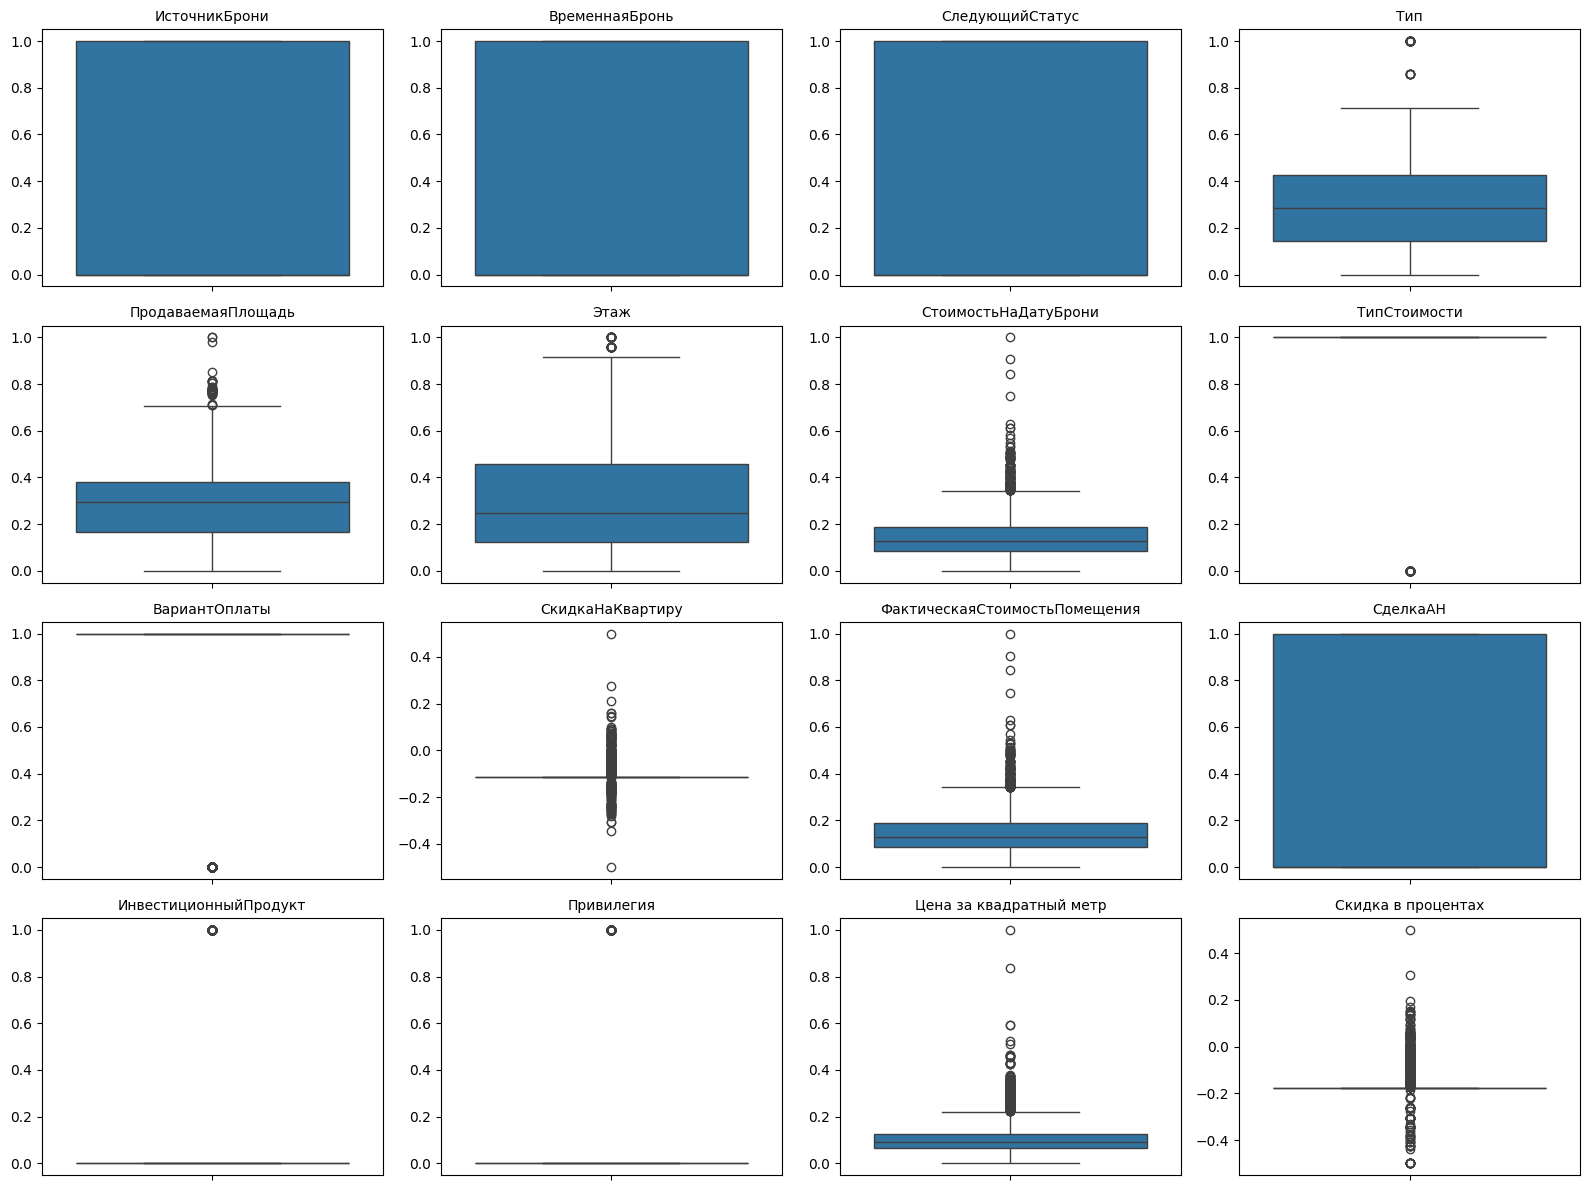

In [27]:
numeric_cols = property_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(y=property_data[col], ax=axes[i])
    axes[i].set_title(col, fontsize=10)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [28]:
filtered_data = property_data.copy()

for col in numeric_cols:
    Q1 = filtered_data[col].quantile(0.25)
    Q3 = filtered_data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_data = filtered_data[(filtered_data[col] >= lower_bound) & (filtered_data[col] <= upper_bound)]

print(f"Исходный размер: {len(property_data)}")
print(f"После фильтрации: {len(filtered_data)}")

filtered_data.info()

Исходный размер: 3941
После фильтрации: 2623
<class 'pandas.core.frame.DataFrame'>
Index: 2623 entries, 0 to 5518
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ИсточникБрони                  2623 non-null   int64  
 1   ВременнаяБронь                 2623 non-null   int64  
 2   СледующийСтатус                2623 non-null   int64  
 3   Тип                            2623 non-null   float64
 4   ПродаваемаяПлощадь             2623 non-null   float64
 5   Этаж                           2623 non-null   float64
 6   СтоимостьНаДатуБрони           2623 non-null   float64
 7   ТипСтоимости                   2623 non-null   int64  
 8   ВариантОплаты                  2623 non-null   float64
 9   СкидкаНаКвартиру               2623 non-null   float64
 10  ФактическаяСтоимостьПомещения  2623 non-null   float64
 11  СделкаАН                       2623 non-null   int64  
 12  Инвестиц

In [29]:
X_filtered = filtered_data[feature_columns]
y_filtered = filtered_data['СледующийСтатус']

X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=23, stratify=y_filtered
)

knn_filtered = KNeighborsClassifier()
knn_filtered.fit(X_train_filtered, y_train_filtered)

tree_filtered = DecisionTreeClassifier(random_state=23)
tree_filtered.fit(X_train_filtered, y_train_filtered)

predictions_knn_filtered = knn_filtered.predict(X_test_filtered)
predictions_tree_filtered = tree_filtered.predict(X_test_filtered)

print("F-мера kNN (после удаления выбросов): " + str(round(f1_score(y_test_filtered, predictions_knn_filtered), 2)))
print("F-мера Tree (после удаления выбросов): " + str(round(f1_score(y_test_filtered, predictions_tree_filtered), 2)))
print("\nPrecision kNN (после удаления выбросов): " + str(round(precision_score(y_test_filtered, predictions_knn_filtered), 2)))
print("Precision Tree (после удаления выбросов): " + str(round(precision_score(y_test_filtered, predictions_tree_filtered), 2)))
print("\nRecall kNN (после удаления выбросов): " + str(round(recall_score(y_test_filtered, predictions_knn_filtered), 2)))
print("Recall Tree (после удаления выбросов): " + str(round(recall_score(y_test_filtered, predictions_tree_filtered), 2)))

F-мера kNN (после удаления выбросов): 0.25
F-мера Tree (после удаления выбросов): 0.31

Precision kNN (после удаления выбросов): 0.39
Precision Tree (после удаления выбросов): 0.31

Recall kNN (после удаления выбросов): 0.19
Recall Tree (после удаления выбросов): 0.31


Удаление выбросов привело к значительному снижению качества предсказаний моделей, возможно из-за нарушения балансировки классов. Проверим это предположение.

In [30]:
print("\nБалансировка после удаления выбросов:")
balance_after = filtered_data['СледующийСтатус'].value_counts(normalize=True)
print(f"Процент класса 0 (отмена): {balance_after[0]*100:.2f}%")
print(f"Процент класса 1 (продажа): {balance_after[1]*100:.2f}%")


Балансировка после удаления выбросов:
Процент класса 0 (отмена): 90.93%
Процент класса 1 (продажа): 9.07%


Действительно, после фильтрации было удалено значительное количество данных о продажах, что привело к снижению качества предсказаний. Это указывает на то, что выбросы содержали важную информацию, и их удаление негативно повлияло на обучающую способность моделей.

16.(2 балла) Выполните подбор параметров для алгоритмов KNN и деревьев решений. Для KNN попробуйте изменять параметр k – количество соседей, для деревьев решений – глубину дерева. Постройте графики зависимости показателей качества от значения параметра (от k в случае KNN и от глубины дерева в случае деревьев решений). Для параметра k рассматривайте диапазон от 1 до 40. Для глубины дерева – от 2 до 40. По графикам определите оптимальные значения параметров

In [31]:
f1_knn_values = []
precision_knn_values = []
recall_knn_values = []
f1_tree_values = []
precision_tree_values = []
recall_tree_values = []

for k in range(1, 41):

    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    predictions = knn_model.predict(X_test)

    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    f1_knn_values.append(f1)
    precision_knn_values.append(precision)
    recall_knn_values.append(recall)

best_k_idx = np.argmax(f1_knn_values)
best_k = 1 + best_k_idx
best_f1_knn = f1_knn_values[best_k_idx]

for depth in range(2, 41):
    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=23)
    tree_model.fit(X_train, y_train)

    predictions = tree_model.predict(X_test)

    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    f1_tree_values.append(f1)
    precision_tree_values.append(precision)
    recall_tree_values.append(recall)

best_depth_idx = np.argmax(f1_tree_values)
best_depth = 2 + best_depth_idx
best_f1_tree = f1_tree_values[best_depth_idx]

/tmp/ipython-input-1721743818.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m-s" (-> color='m'). The keyword argument will take precedence.
  plt.plot(range(1, 41), f1_knn_values, 'm-s', linewidth=2, markersize=6, color='darkviolet')  # Темно-фиолетовый
/tmp/ipython-input-1721743818.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "c-^" (-> color='c'). The keyword argument will take precedence.
  plt.plot(range(1, 41), precision_knn_values, 'c-^', label='Precision', linewidth=2, markersize=6, color='teal')  # Темно-бирюзовый
/tmp/ipython-input-1721743818.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y-D" (-> color='y'). The keyword argument will take precedence.
  plt.plot(range(1, 41), recall_knn_values, 'y-D', label='Recall', linewidth=2, markersize=6, color='goldenrod')  # Золотистый


([<matplotlib.axis.XTick at 0x782cd7b456d0>,
 [Text(1, 0, '1'),
  Text(6, 0, '6'),
  Text(11, 0, '11'),
  Text(16, 0, '16'),
  Text(21, 0, '21'),
  Text(26, 0, '26'),
  Text(31, 0, '31'),
  Text(36, 0, '36')])

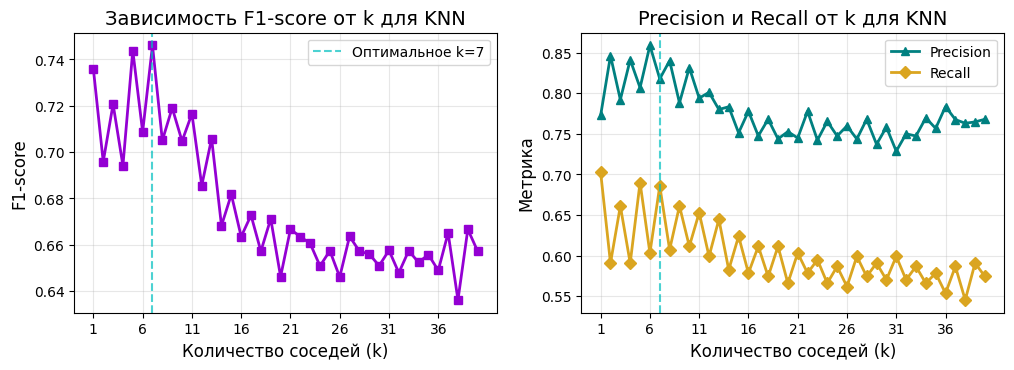

In [32]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(range(1, 41), f1_knn_values, 'm-s', linewidth=2, markersize=6, color='darkviolet')  # Темно-фиолетовый
plt.axvline(x=best_k, color='c', linestyle='--', alpha=0.7, label=f'Оптимальное k={best_k}')  # Бирюзовый
plt.xlabel('Количество соседей (k)', fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.title('Зависимость F1-score от k для KNN', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(1, 41, 5))

plt.subplot(2, 2, 2)
plt.plot(range(1, 41), precision_knn_values, 'c-^', label='Precision', linewidth=2, markersize=6, color='teal')  # Темно-бирюзовый
plt.plot(range(1, 41), recall_knn_values, 'y-D', label='Recall', linewidth=2, markersize=6, color='goldenrod')  # Золотистый
plt.axvline(x=best_k, color='c', linestyle='--', alpha=0.7)  # Бирюзовый
plt.xlabel('Количество соседей (k)', fontsize=12)
plt.ylabel('Метрика', fontsize=12)
plt.title('Precision и Recall от k для KNN', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(1, 41, 5))

/tmp/ipython-input-2351360551.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m-s" (-> color='m'). The keyword argument will take precedence.
  plt.plot(range(2, 41), f1_tree_values, 'm-s', linewidth=2, markersize=6, color='darkviolet')  # Фиолетовый
/tmp/ipython-input-2351360551.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "c-^" (-> color='c'). The keyword argument will take precedence.
  plt.plot(range(2, 41), precision_tree_values, 'c-^', label='Precision', linewidth=2, markersize=6, color='teal')  # Темно-бирюзовый
/tmp/ipython-input-2351360551.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y-D" (-> color='y'). The keyword argument will take precedence.
  plt.plot(range(2, 41), recall_tree_values, 'y-D', label='Recall', linewidth=2, markersize=6, color='goldenrod')  # Золотистый


([<matplotlib.axis.XTick at 0x782cd82c3170>,
 [Text(2, 0, '2'),
  Text(7, 0, '7'),
  Text(12, 0, '12'),
  Text(17, 0, '17'),
  Text(22, 0, '22'),
  Text(27, 0, '27'),
  Text(32, 0, '32'),
  Text(37, 0, '37')])

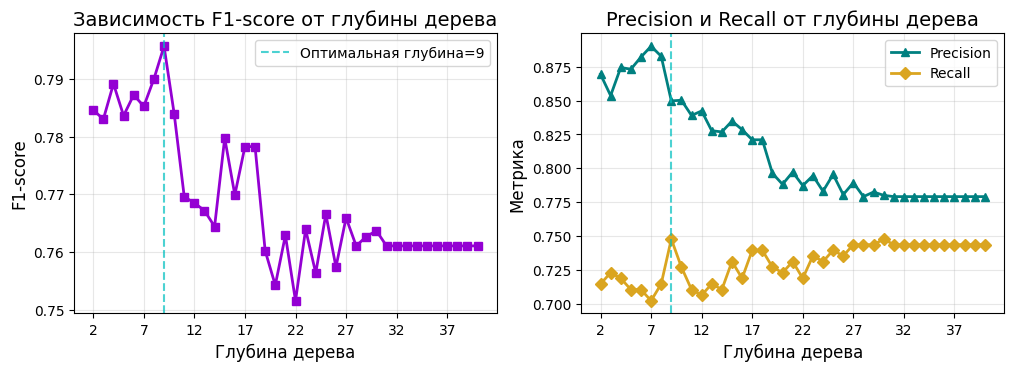

In [33]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(range(2, 41), f1_tree_values, 'm-s', linewidth=2, markersize=6, color='darkviolet')  # Фиолетовый
plt.axvline(x=best_depth, color='c', linestyle='--', alpha=0.7, label=f'Оптимальная глубина={best_depth}')  # Бирюзовый
plt.xlabel('Глубина дерева', fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.title('Зависимость F1-score от глубины дерева', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(2, 41, 5))

plt.subplot(2, 2, 2)
plt.plot(range(2, 41), precision_tree_values, 'c-^', label='Precision', linewidth=2, markersize=6, color='teal')  # Темно-бирюзовый
plt.plot(range(2, 41), recall_tree_values, 'y-D', label='Recall', linewidth=2, markersize=6, color='goldenrod')  # Золотистый
plt.axvline(x=best_depth, color='c', linestyle='--', alpha=0.7)  # Бирюзовый
plt.xlabel('Глубина дерева', fontsize=12)
plt.ylabel('Метрика', fontsize=12)
plt.title('Precision и Recall от глубины дерева', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(2, 41, 5))

17. (1 балл) Из библиотеки sklearn.linear_model возьмите алгоритм логистической регрессии (LogisticRegression). Постройте (обучите) модель. Посчитайте показатели качества. Сравните результат с другими моделями.

In [34]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

predictions_logistic = logistic_model.predict(X_test)

print("F-мера Logistic: " + str(round(f1_score(y_test, predictions_logistic), 2)))
print("Precision Logistic: " + str(round(precision_score(y_test, predictions_logistic), 2)))
print("Recall Logistic: " + str(round(recall_score(y_test, predictions_logistic), 2)))

F-мера Logistic: 0.73
Precision Logistic: 0.86
Recall Logistic: 0.63


Сравнение с методами kNN и дерева решений демонстрирует повышение точности (Precision), однако сопровождается снижением остальных метрик качества. Поскольку F-мера является более общей характеристикой, а полнота (Recall) значительно уменьшилась, модель дерева решений по-прежнему остается наиболее эффективным решением.

18. (1 балл) Из библиотеки sklearn.svm возьмите алгоритм SVM (машины опорных векторов) (LinearSVC). Постройте (обучите) модель. Посчитайте показатели качества. Сравните результат с другими моделями.

In [35]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

predictions_svm = svm_model.predict(X_test)

print("F-мера SVM: " + str(round(f1_score(y_test, predictions_svm), 2)))
print("Precision SVM: " + str(round(precision_score(y_test, predictions_svm), 2)))
print("Recall SVM: " + str(round(recall_score(y_test, predictions_svm), 2)))

F-мера SVM: 0.77
Precision SVM: 0.87
Recall SVM: 0.68


Сравнительный анализ четырех алгоритмов классификации выявил, что метод SVM (LinearSVC) достигает наилучших результатов с F1-мерой 0.77. Данная модель обеспечивает высокую точность предсказаний (Precision=0.87) при сохранении удовлетворительной полноты обнаружения реальных продаж (Recall=0.68)